### Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
#creating path
path = r"C:\Users\Sreelaya Narla\Desktop\Achievement 6\chocolate bar ratings analysis"

In [4]:
# Import data

df = pd.read_csv(os.path.join(path, '02 data', 'prepared data', 'cleaned_flavors_of_cacao.csv'))

### data cleaning

In [5]:
# Drop columns not used in EDA
for col in ['REF', 'Specific_Bean_Origin_or_Bar_Name' ]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [6]:
#Now rename the cleaned header
df.rename(columns={'Company_(Maker-if_known)' : 'Company'}, inplace=True)
df.columns.tolist()

['Company',
 'Review_Date',
 'Cocoa_Percent',
 'Company_Location',
 'Rating',
 'Bean_Type',
 'Broad_Bean_Origin']

In [7]:
# Rename 'Broad_Bean_Origin' to Country to match GeoJSON 
df = df.rename(columns={'Broad_Bean_Origin':'Country'})

to turn the chocolate data into a usable time series.
-build a series of average chocolate ratings per year (and optionally cocoa % per year) using  Review_Date.

In [8]:
# Step 1: Aggregate average Rating per year
ts = df.groupby("Review_Date")["Rating"].mean().reset_index()

In [9]:
# Step 2: Set Review_Date as a datetime index
ts["Review_Date"] = pd.to_datetime(ts["Review_Date"], format="%Y")
ts.set_index("Review_Date", inplace=True)

In [10]:
# Preview
ts.head()


,Rating
Review_Date,
2006-01-01,3.125000
2007-01-01,3.162338
2008-01-01,2.994624
2009-01-01,3.073171
2010-01-01,3.148649


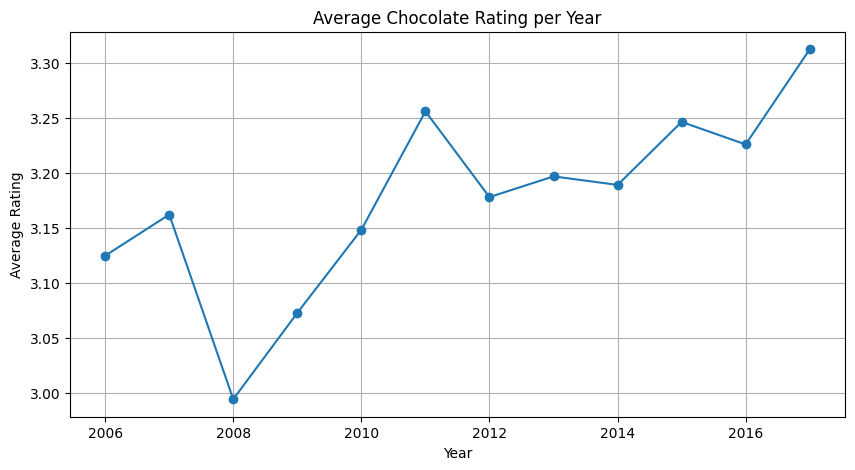

In [11]:
# Step 3: Plot the time series
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts["Rating"], marker="o")
plt.title("Average Chocolate Rating per Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

In [12]:
# OPTIONAL: Add Cocoa_Percent as well
ts2 = df.groupby("Review_Date")["Cocoa_Percent"].mean().reset_index()
ts2["Review_Date"] = pd.to_datetime(ts2["Review_Date"], format="%Y")
ts2.set_index("Review_Date", inplace=True)


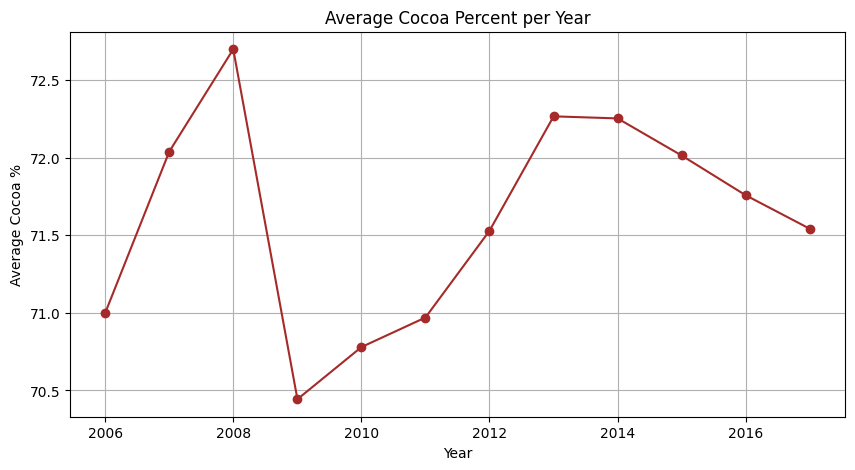

In [13]:
plt.figure(figsize=(10,5))
plt.plot(ts2.index, ts2["Cocoa_Percent"], color="brown", marker="o")
plt.title("Average Cocoa Percent per Year")
plt.xlabel("Year")
plt.ylabel("Average Cocoa %")
plt.grid(True)
plt.show()

### Decompose the time series

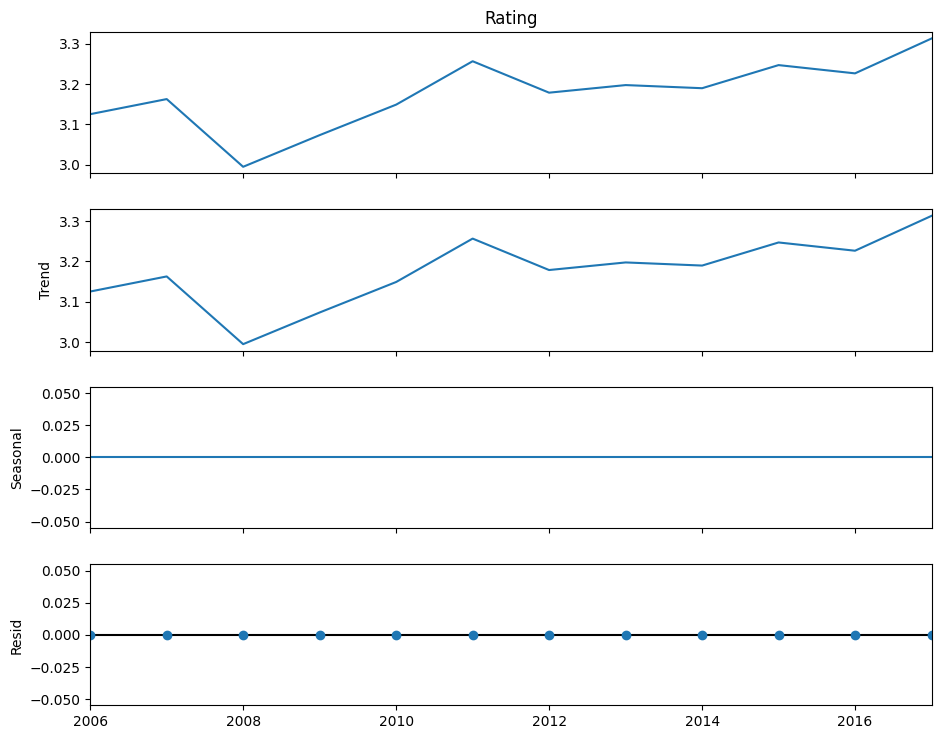

In [14]:
#use additive decomposition to see trend & seasonality
decomposition = sm.tsa.seasonal_decompose(ts["Rating"], model="additive", period=1)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

### Dickey-Fuller Test for Stationarity

The ADF test checks if the series is stationary.

Null hypothesis (H0): Series is non-stationary.

Alternative hypothesis (H1): Series is stationary.
Interpretation:

If p-value < 0.05 → reject H0 → data is stationary.

If p-value > 0.05 → fail to reject H0 → data is not stationary → need differencing.

In [15]:
result = adfuller(ts["Rating"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -1.237766053600439
p-value: 0.6571424709520042
Critical Value (1%): -4.6651863281249994
Critical Value (5%): -3.3671868750000002
Critical Value (10%): -2.802960625


Interpretation of Dickey-Fuller Test

ADF Statistic: -1.238

p-value: 0.657

Critical Values:

1%: -4.665

5%: -3.367

10%: -2.803

 Since the p-value (0.657) > 0.05, we fail to reject the null hypothesis.
This means the chocolate ratings time series is not stationary — it has trends or structure that prevent it from being purely random.

### differencing

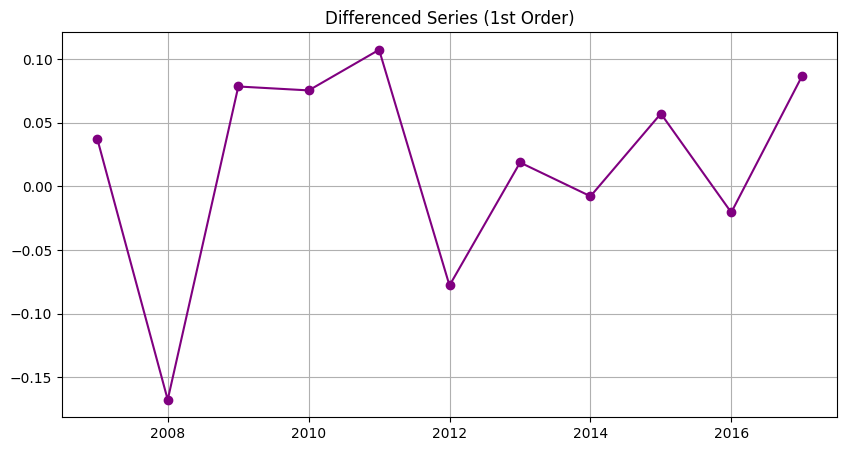

ADF Statistic: -5.667874325830317
p-value: 9.063532737869093e-07


In [16]:
ts_diff = ts["Rating"].diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(ts_diff, marker="o", color="purple")
plt.title("Differenced Series (1st Order)")
plt.grid(True)
plt.show()

# Run ADF test again
result = adfuller(ts_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


Interpretation After Differencing

ADF Statistic: -5.668

p-value: 9.06e-07

Critical Values:

1%: -4.665

5%: -3.367

10%: -2.803

 Since the p-value is far below 0.05, we reject the null hypothesis.
This means the differenced chocolate ratings series is now stationary.

 Why Differencing Was Necessary

The original chocolate ratings time series had trends (non-stationary behavior). Differencing helped remove these trends, making the series more stable and better suited for time-series forecasting methods like ARIMA.

### Autocorrelation Check (ACF & PACF)

ValueError: could not broadcast input array from shape (11,) into shape (21,)

<Figure size 1000x500 with 0 Axes>

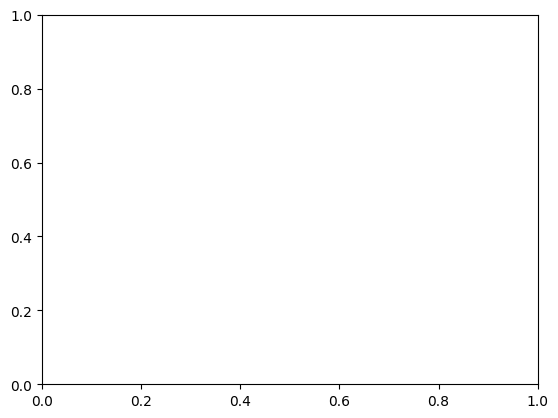

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,5))
plot_acf(ts_diff, lags=20)
plt.show()

plt.figure(figsize=(10,5))
plot_pacf(ts_diff, lags=20)
plt.show()


In [18]:
#drop Nan values
ts_diff = ts_diff.dropna()


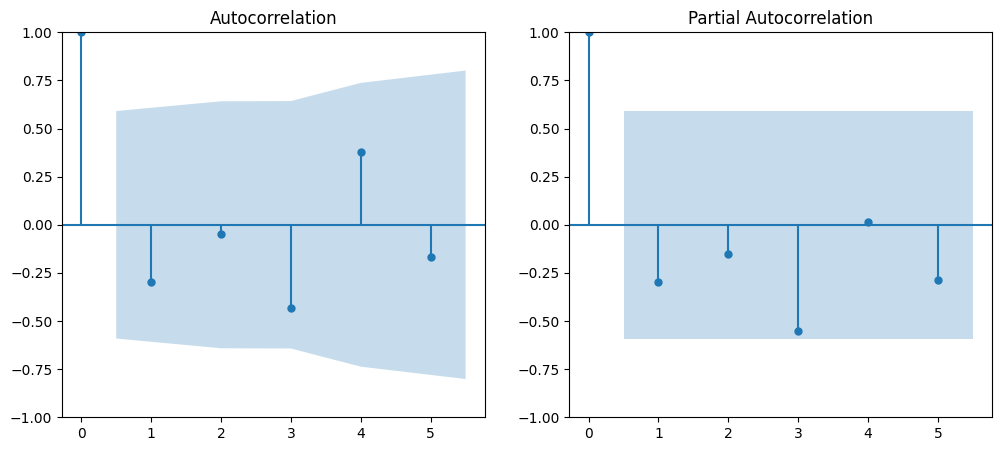

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Drop NA if not already done
ts_diff = ts_diff.dropna()

# Choose lags safely (max 10% of series length is a good rule)
max_lags = min(20, len(ts_diff)//2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(ts_diff, lags=max_lags, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(ts_diff, lags=max_lags, ax=plt.gca())
plt.show()


After differencing the cocoa rating time series, the ADF test confirmed stationarity. The ACF plot shows a strong negative correlation at lag 1 and weaker correlations at higher lags, while the PACF plot shows a sharp negative spike at lag 1 and no strong correlations beyond that. This suggests that an AR(1) or ARIMA(1,1,1) model may be appropriate for capturing the dynamics of the series. These findings will guide the selection of parameters in the next step of the ARIMA modeling pipeline.

In [20]:
ts.reset_index().to_csv(os.path.join(path, '02 data', 'prepared data', 'avg_rating_by_year.csv'), index=False)